<a href="https://colab.research.google.com/github/Gulzar-khan/ML-PRACTICE/blob/main/Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anomaly detection

Anomaly detection is the process of identifying unexpected items or events in data sets, which differ from the norm. And anomaly detection is often applied on unlabeled data which is known as unsupervised anomaly detection.

Anomaly detection has two basic assumptions:
* Anomalies only occur very rarely in the data.
* Their features differ from the normal instances significantly.

## Univariate Anomaly Detection

Before we get to Multivariate anomaly detection, its necessary to work through a simple example of Univariate anomaly detection method in which we detect outliers from a distribution of values in a single feature space.

We are using a super store sales data set, and we are going to find patterns in Sales and Profit separately that do not conform to expected behavior. That is, spotting outliers for one variable at a time.

In [ ]:
!pip install --upgrade xlrd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import IsolationForest

from scipy import stats

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/Almabetter/ML/week 13/1. Anomaly Detection/Superstore.xls")

In [ ]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


### Sales Variable Analysis

In [ ]:
df.Sales.describe()

count     9994.000000
mean       229.858001
std        623.245101
min          0.444000
25%         17.280000
50%         54.490000
75%        209.940000
max      22638.480000
Name: Sales, dtype: float64

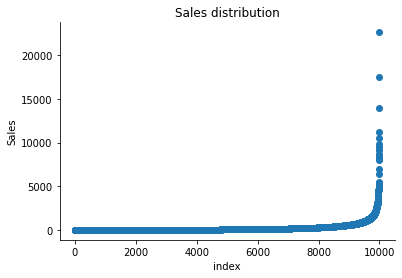

In [ ]:
plt.scatter(range(df.shape[0]), np.sort(df['Sales'].values))
plt.xlabel('index')
plt.ylabel('Sales')
plt.title("Sales distribution")
sns.despine()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


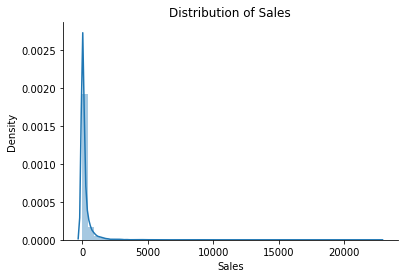

In [ ]:
sns.distplot(df['Sales'])
plt.title("Distribution of Sales")
sns.despine()

In [ ]:
print("Skewness: %f" % df['Sales'].skew())
print("Kurtosis: %f" % df['Sales'].kurt())

Skewness: 12.972752
Kurtosis: 305.311753


The Superstore’s sales distribution is far from a normal distribution, and it has a positive long thin tail, the mass of the distribution is concentrated on the left of the figure. And the tail sales distribution far exceeds the tails of the normal distribution.
There are one region where the data has low probability to appear which is on the right side of the distribution.

### Profit Variable Analysis

In [ ]:
df.Profit.describe()

count    9994.000000
mean       28.656896
std       234.260108
min     -6599.978000
25%         1.728750
50%         8.666500
75%        29.364000
max      8399.976000
Name: Profit, dtype: float64

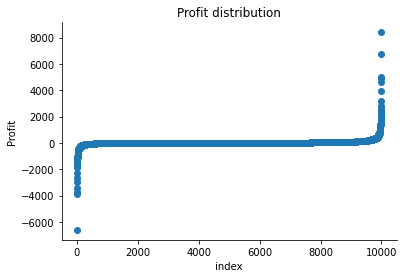

In [ ]:
plt.scatter(range(df.shape[0]), np.sort(df['Profit'].values))
plt.xlabel('index')
plt.ylabel('Profit')
plt.title("Profit distribution")
sns.despine()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


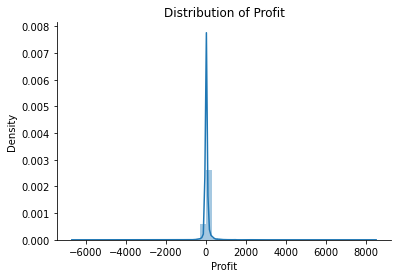

In [ ]:
sns.distplot(df['Profit'])
plt.title("Distribution of Profit")
sns.despine()

In [ ]:
print("Skewness: %f" % df['Profit'].skew())
print("Kurtosis: %f" % df['Profit'].kurt())

Skewness: 7.561432
Kurtosis: 397.188515


The Superstore’s Profit distribution has both a positive tail and negative tail. However, the positive tail is longer than the negative tail. So the distribution is positive skewed, and the data are heavy-tailed or profusion of outliers.
There are two regions where the data has low probability to appear: one on the right side of the distribution, another one on the left.

### Univariate Anomaly Detection on Sales

## Isolation Forest

Isolation Forest is an algorithm to detect outliers that returns the anomaly score of each sample using the IsolationForest algorithm which is based on the fact that anomalies are data points that are few and different. Isolation Forest is a tree-based model. In these trees, partitions are created by first randomly selecting a feature and then selecting a random split value between the minimum and maximum value of the selected feature.

The following process shows how IsolationForest behaves in the case of the Susperstore’s sales, and the algorithm is implemented in Sklearn:

* Trained IsolationForest using the Sales data.
* Store the Sales in the NumPy array for using in our models later.
* Computed the anomaly score for each observation. The anomaly score of an input sample is computed as the mean anomaly score of the trees in the forest.
* Classified each observation as an outlier or non-outlier.
* The visualization highlights the regions where the outliers fall.

In [ ]:
isolation_forest = IsolationForest(n_estimators=100, contamination=0.01)
isolation_forest.fit(df['Sales'].values.reshape(-1, 1))
df['anomaly_score_univariate_sales'] = isolation_forest.decision_function(df['Sales'].values.reshape(-1, 1))
df['outlier_univariate_sales'] = isolation_forest.predict(df['Sales'].values.reshape(-1, 1))

In [ ]:
df.sort_values('anomaly_score_univariate_sales')

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,anomaly_score_univariate_sales,outlier_univariate_sales
2697,2698,CA-2014-145317,2014-03-18,2014-03-23,Standard Class,SM-20320,Sean Miller,Home Office,United States,Jacksonville,...,TEC-MA-10002412,Technology,Machines,Cisco TelePresence System EX90 Videoconferenci...,22638.480,6,0.5,-1811.0784,-0.118418,-1
6826,6827,CA-2016-118689,2016-10-02,2016-10-09,Standard Class,TC-20980,Tamara Chand,Corporate,United States,Lafayette,...,TEC-CO-10004722,Technology,Copiers,Canon imageCLASS 2200 Advanced Copier,17499.950,5,0.0,8399.9760,-0.116671,-1
2623,2624,CA-2017-127180,2017-10-22,2017-10-24,First Class,TA-21385,Tom Ashbrook,Home Office,United States,New York City,...,TEC-CO-10004722,Technology,Copiers,Canon imageCLASS 2200 Advanced Copier,11199.968,4,0.2,3919.9888,-0.114346,-1
4190,4191,CA-2017-166709,2017-11-17,2017-11-22,Standard Class,HL-15040,Hunter Lopez,Consumer,United States,Newark,...,TEC-CO-10004722,Technology,Copiers,Canon imageCLASS 2200 Advanced Copier,10499.970,3,0.0,5039.9856,-0.114346,-1
8153,8154,CA-2017-140151,2017-03-23,2017-03-25,First Class,RB-19360,Raymond Buch,Consumer,United States,Seattle,...,TEC-CO-10004722,Technology,Copiers,Canon imageCLASS 2200 Advanced Copier,13999.960,4,0.0,6719.9808,-0.114346,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7887,7888,CA-2017-118017,2017-12-03,2017-12-06,Second Class,LC-16870,Lena Cacioppo,Consumer,United States,Thornton,...,FUR-FU-10004053,Furniture,Furnishings,DAX Two-Tone Silver Metal Document Frame,16.192,1,0.2,4.6552,0.359320,1
7847,7848,CA-2016-128706,2016-02-27,2016-03-02,Standard Class,DW-13540,Don Weiss,Consumer,United States,Houston,...,FUR-FU-10004053,Furniture,Furnishings,DAX Two-Tone Silver Metal Document Frame,16.192,2,0.6,-6.8816,0.359320,1
3437,3438,CA-2017-152583,2017-10-30,2017-10-30,Same Day,RA-19945,Ryan Akin,Consumer,United States,Dallas,...,FUR-FU-10003849,Furniture,Furnishings,"DAX Metal Frame, Desktop, Stepped-Edge",16.192,2,0.6,-8.5008,0.359320,1
1809,1810,CA-2016-165484,2016-10-23,2016-10-29,Standard Class,HK-14890,Heather Kirkland,Corporate,United States,Chicago,...,FUR-FU-10001196,Furniture,Furnishings,DAX Cubicle Frames - 8x10,16.156,7,0.6,-12.1170,0.359542,1


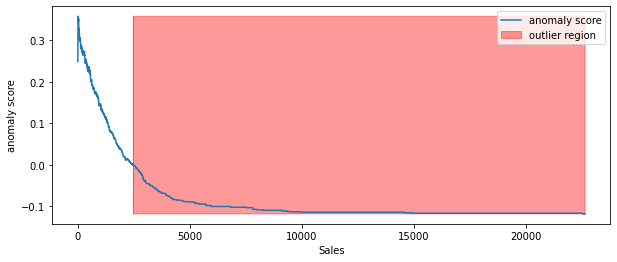

In [ ]:
xx = np.linspace(df['Sales'].min(), df['Sales'].max(), len(df)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)

plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score),
                 where=outlier==-1, color='r',
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Sales')
plt.show();

According to the above results and visualization, it seems that sales that exceeds 1500 would be definitely considered as an outlier.

### Anomaly detection on Profit

In [ ]:
isolation_forest = IsolationForest(n_estimators=100, contamination=0.01)
isolation_forest.fit(df['Profit'].values.reshape(-1, 1))
df['anomaly_score_univariate_profit'] = isolation_forest.decision_function(df['Profit'].values.reshape(-1, 1))
df['outlier_univariate_profit'] = isolation_forest.predict(df['Profit'].values.reshape(-1, 1))

In [ ]:
df.sort_values('anomaly_score_univariate_profit')

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,anomaly_score_univariate_sales,outlier_univariate_sales,anomaly_score_univariate_profit,outlier_univariate_profit
7772,7773,CA-2016-108196,2016-11-25,2016-12-02,Standard Class,CS-12505,Cindy Stewart,Consumer,United States,Lancaster,...,Machines,Cubify CubeX 3D Printer Double Head Print,4499.985,5,0.7,-6599.9780,-0.085258,-1,-0.072674,-1
3011,3012,CA-2017-134845,2017-04-17,2017-04-23,Standard Class,SR-20425,Sharelle Roach,Home Office,United States,Louisville,...,Machines,Lexmark MX611dhe Monochrome Laser Printer,2549.985,5,0.7,-3399.9800,-0.002917,-1,-0.070395,-1
683,684,US-2017-168116,2017-11-04,2017-11-04,Same Day,GT-14635,Grant Thornton,Corporate,United States,Burlington,...,Machines,Cubify CubeX 3D Printer Triple Head Print,7999.980,4,0.5,-3839.9904,-0.108563,-1,-0.070395,-1
9774,9775,CA-2014-169019,2014-07-26,2014-07-30,Standard Class,LF-17185,Luke Foster,Consumer,United States,San Antonio,...,Binders,GBC DocuBind P400 Electric Binding System,2177.584,8,0.8,-3701.8928,0.014052,1,-0.070395,-1
6826,6827,CA-2016-118689,2016-10-02,2016-10-09,Standard Class,TC-20980,Tamara Chand,Corporate,United States,Lafayette,...,Copiers,Canon imageCLASS 2200 Advanced Copier,17499.950,5,0.0,8399.9760,-0.116671,-1,-0.066988,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6395,6396,CA-2016-129126,2016-12-14,2016-12-19,Standard Class,PK-19075,Pete Kriz,Consumer,United States,New York City,...,Storage,Advantus Rolling Storage Box,17.150,1,0.0,4.6305,0.355976,1,0.448745,1
6387,6388,CA-2014-134103,2014-01-30,2014-02-04,Standard Class,MV-18190,Mike Vittorini,Consumer,United States,Detroit,...,Paper,Xerox 1972,10.560,2,0.0,4.7520,0.351801,1,0.448745,1
6301,6302,US-2014-161305,2014-06-06,2014-06-12,Standard Class,SB-20170,Sarah Bern,Consumer,United States,Chicago,...,Envelopes,"#10- 4 1/8"" x 9 1/2"" Recycled Envelopes",13.984,2,0.2,4.7196,0.350470,1,0.448745,1
2288,2289,CA-2017-143343,2017-06-10,2017-06-13,First Class,BW-11200,Ben Wallace,Consumer,United States,Los Angeles,...,Art,Newell 351,16.400,5,0.0,4.7560,0.357960,1,0.448745,1


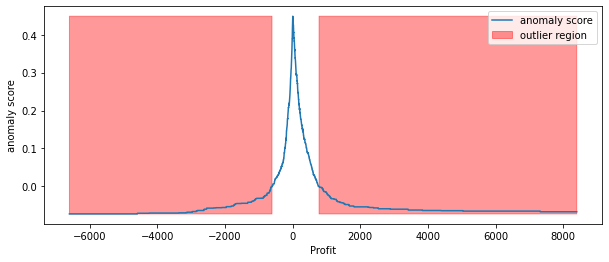

In [ ]:
xx = np.linspace(df['Profit'].min(), df['Profit'].max(), len(df)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)
plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score),
                 where=outlier==-1, color='r',
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Profit')
plt.show();

According to the above results and visualization, it seems Profit that is below -100 or exceeds 100 would be considered as an outlier.

In [ ]:
df[(df['outlier_univariate_profit']==-1) & (df['outlier_univariate_sales']==-1)]

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,anomaly_score_univariate_sales,outlier_univariate_sales,anomaly_score_univariate_profit,outlier_univariate_profit
27,28,US-2015-150630,2015-09-17,2015-09-21,Standard Class,TB-21520,Tracy Blumstein,Consumer,United States,Philadelphia,...,Bookcases,"Riverside Palais Royal Lawyers Bookcase, Royal...",3083.430,7,0.5,-1665.0522,-0.045330,-1,-0.045729,-1
165,166,CA-2014-139892,2014-09-08,2014-09-12,Standard Class,BM-11140,Becky Martin,Consumer,United States,San Antonio,...,Machines,Lexmark MX611dhe Monochrome Laser Printer,8159.952,8,0.4,-1359.9920,-0.108563,-1,-0.044625,-1
318,319,CA-2014-164973,2014-11-04,2014-11-09,Standard Class,NM-18445,Nathan Mautz,Home Office,United States,New York City,...,Machines,Canon imageCLASS MF7460 Monochrome Digital Las...,3991.980,2,0.0,1995.9900,-0.074122,-1,-0.054056,-1
353,354,CA-2016-129714,2016-09-01,2016-09-03,First Class,AB-10060,Adam Bellavance,Home Office,United States,New York City,...,Binders,GBC DocuBind P400 Electric Binding System,4355.168,4,0.2,1415.4296,-0.084138,-1,-0.042422,-1
509,510,CA-2015-145352,2015-03-16,2015-03-22,Standard Class,CM-12385,Christopher Martinez,Consumer,United States,Atlanta,...,Binders,Fellowes PB500 Electric Punch Plastic Comb Bin...,6354.950,5,0.0,3177.4750,-0.100533,-1,-0.060216,-1
515,516,CA-2017-127432,2017-01-22,2017-01-27,Standard Class,AD-10180,Alan Dominguez,Home Office,United States,Great Falls,...,Copiers,Canon Image Class D660 Copier,2999.950,5,0.0,1379.9770,-0.039483,-1,-0.040773,-1
683,684,US-2017-168116,2017-11-04,2017-11-04,Same Day,GT-14635,Grant Thornton,Corporate,United States,Burlington,...,Machines,Cubify CubeX 3D Printer Triple Head Print,7999.980,4,0.5,-3839.9904,-0.108563,-1,-0.070395,-1
994,995,CA-2014-117639,2014-05-21,2014-05-25,Standard Class,MW-18235,Mitch Willingham,Corporate,United States,Virginia Beach,...,Binders,Fellowes PB300 Plastic Comb Binding Machine,2715.930,7,0.0,1276.4871,-0.013595,-1,-0.034213,-1
1085,1086,US-2016-143819,2016-03-01,2016-03-05,Standard Class,KD-16270,Karen Daniels,Consumer,United States,Yonkers,...,Machines,Ativa V4110MDD Micro-Cut Shredder,4899.930,7,0.0,2400.9657,-0.089191,-1,-0.056850,-1
1454,1455,CA-2016-133711,2016-11-26,2016-11-29,First Class,MC-17425,Mark Cousins,Corporate,United States,Mobile,...,Machines,Hewlett-Packard Deskjet 3050a All-in-One Color...,3040.000,8,0.0,1459.2000,-0.041604,-1,-0.043523,-1


The above two visualizations show the anomaly scores and highlighted the regions where the outliers are. As expected, the anomaly score reflects the shape of the underlying distribution and the outlier regions correspond to low probability areas.

However, univariate analysis can only get us thus far. We may realize that some of these anomalies that determined by our models are anomalous in context of one variable but not the other. When our data is multidimensional as opposed to univariate, the approaches to anomaly detection become more computationally intensive and more mathematically complex.

# Multivariate Anomaly Detection

Most of the analysis that we end up doing are multivariate due to complexity of the world we are living in. In multivariate anomaly detection, outlier is a combined unusual score on at least two variables.

So, using the Sales and Profit variables, we are going to build an unsupervised multivariate anomaly detection model.

### Sales & Profit

When we are in business, we expect that Sales & Profit are positive correlated. If some of the Sales data points and Profit data points are not positive correlated, they would be considered as outliers and need to be further investigated.

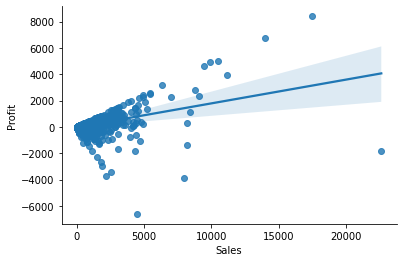

In [ ]:
sns.regplot(x="Sales", y="Profit", data=df)
sns.despine();

From the above correlation chart, we can see that some of the data points are obvious outliers such as extreme low and extreme high values.

In [ ]:
minmax = MinMaxScaler(feature_range=(0, 1))
X = minmax.fit_transform(df[['Sales','Profit']])

In [ ]:
clf = IsolationForest(n_estimators=100, contamination=0.01, random_state=0)
clf.fit(X)

# predict raw anomaly score
df['multivariate_anomaly_score'] = clf.decision_function(X)

# prediction of a datapoint category outlier or inlier
df['multivariate_outlier'] = clf.predict(X)

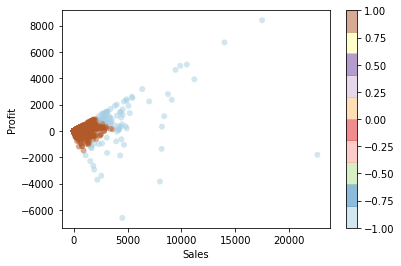

In [ ]:
plt.scatter(df['Sales'], df['Profit'],
            c=df.multivariate_outlier, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Paired', 10))
plt.xlabel('Sales')
plt.ylabel('Profit')
plt.colorbar();

### Visually investigate some of the anomalies

We may want to investigate each of the outliers that determined by our model and try to understand what make them anomalies.

In [ ]:
df[(df['outlier_univariate_sales'] == 1) & (df['outlier_univariate_profit'] == 1) & (df['multivariate_outlier'] == -1)]


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,anomaly_score_univariate_sales,outlier_univariate_sales,anomaly_score_univariate_profit,outlier_univariate_profit,multivariate_anomaly_score,multivariate_outlier
5530,5531,CA-2017-160885,2017-12-02,2017-12-06,Standard Class,JK-16090,Juliana Krohn,Consumer,United States,Omaha,Nebraska,68104,Central,TEC-PH-10001795,Technology,Phones,ClearOne CHATAttach 160 - speaker phone,2479.96,4,0.0,743.988,0.00111,1,0.00203,1,-0.003456,-1
